In [1]:
import pandas as pd
import numpy as np
import re
from keras.layers import Dense,GaussianNoise,LeakyReLU,Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB,CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


Using TensorFlow backend.


## Чтение и предварительная обработка данных

In [2]:
train=open('svmdata4.txt','r') # читаем файл с тренировочной выборкой
train = train.read().splitlines() #  разделяем текст на строки
test=open('svmdata4test.txt','r') # читаем файл с тестовой выборкой
test=test.read().splitlines()

Удаляем первую строку, содрежащую индексы

In [3]:
train.pop(0)
test.pop(0)

'X1\tX2\tColors'

Создаем numpy массивы из данных

In [4]:
train_data=np.array(train)
test_data=np.array(test)

Создаем пустую обучающую выборку, условимся, что red - 0, green - 1

In [5]:
width=2 # ширина двумерного массива, т.к. мы имеем два числа, определющих выборку
train_length=train_data.shape[0] # длина массива тренировочных данных
test_length=test_data.shape[0] # длнна массива тестовых данных


# подготавливаем массивы необходимых размеров
x_train=np.ones((train_length,width))
y_train=np.ones((train_length,1))
x_test=np.ones((test_length,width))
y_test=np.ones((test_length,1))

Создаем на основе считанных файлов выборки

In [6]:
for i,line in enumerate(train_data): # заполняем тренировочный массив  
        data=re.split(r'\t',line)    
        # разделяем каждую строку по символу табуляции
        x_train[i][0]=float(data[1]) # заполняем массив координат
        x_train[i][1]=float(data[2])
        if data[3]=='red': # заполняем массив y 
            y_train[i]=0  
        else:
            y_train[i]=1
            

for i,line in enumerate(test_data): # по аналогии заполняем тестовый массив
        data=re.split(r'\t',line)
        x_test[i][0]=float(data[1])
        x_test[i][1]=float(data[2])
        if data[3]=='red':
            y_test[i]=0
        else:
            y_test[i]=1

Нормализуем обучающиую выборку

In [7]:
print('Первая строка до нормализации',x_train[0])
means = x_train.mean(axis=0) # определим среднее
stds = x_train.std(axis=0)   # определим дисперсию
# нормализовать будем следующим образом:
# разделим разницу между значением каждой ячейки массива и дисперсией на среднее
for i in range(x_train.shape[0]):
    for j in range(x_train.shape[1]):
        x_train[i][j]=(x_train[i][j]-means[j])/stds[j]

print('Первая строка после нормализации',x_train[0])
print('Среднее арифметическое по стобцам ',means)
print('Дисперсия по столбцам' ,stds)

Первая строка до нормализации [11.50308712 -0.87201722]
Первая строка после нормализации [ 1.4989743  -0.73414582]
Среднее арифметическое по стобцам  [ 6.16973542 -0.01688913]
Дисперсия по столбцам [3.55800075 1.16479323]


Нормализуем тестовую выборку

In [8]:
# воспользуемся тем же методом нормализации
for i in range(x_test.shape[0]):
    for j in range(x_test.shape[1]):
        x_test[i][j]=(x_test[i][j]-means[j])/stds[j]

## Создадим модель нейронной сети

In [9]:
# сформируем простую нейронную сеть
# из пакета keras возьмем модель Sequential (с последовательно связанными слоями)
model=Sequential()

#добавим нормального(гауссого) шума ,чтобы избежать переобучения
model.add(GaussianNoise(stddev=0.03,input_shape=(2,)))

# добавим первый слой нейронов
model.add(Dense(256))
# добавим функцию активации LeakyReLU,
# которая отсекает у функции ReLu нулевые значения,
# изменяя их на a*x, где в нашем случае a = 0.2
#(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU
model.add(LeakyReLU(0.2))
# по аналогии создадим второй слой, уменьшив количество нейронов в 2 раза
model.add(Dense(128))
model.add(LeakyReLU(0.2))
# т.к. наша задача - задача бинарной классификации,
# то на выходе нам достаточо 1 нейрона
model.add(Dense(1))
# и функцию активации - sigmoid
model.add(Activation('sigmoid'))

In [10]:
# выведем полученную модель на экран
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [11]:
batch=2 # количество элементов единовременно используемых для обучения
epochs=150 # количество циклов обучения 
validation_split=0.25 # количество данных, используемых для валидации непосредственно во время обучения

# для задачи бинарной классификации воспользуемся функцией потерь binary_crossentropy
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
        
history=model.fit(x_train,y_train,batch_size=batch,epochs=epochs,verbose=True,validation_split=validation_split)

Train on 150 samples, validate on 50 samples
Epoch 1/150
150/150 [==============================] - 0s 2ms/step - loss: 0.3525 - accuracy: 0.8467 - val_loss: 0.2221 - val_accuracy: 0.8800
Epoch 2/150
150/150 [==============================] - 0s 1ms/step - loss: 0.2826 - accuracy: 0.8533 - val_loss: 0.2027 - val_accuracy: 0.9000
Epoch 3/150
150/150 [==============================] - 0s 970us/step - loss: 0.2690 - accuracy: 0.8733 - val_loss: 0.2021 - val_accuracy: 0.9200
Epoch 4/150
150/150 [==============================] - 0s 1ms/step - loss: 0.2882 - accuracy: 0.8733 - val_loss: 0.1983 - val_accuracy: 0.9000
Epoch 5/150
150/150 [==============================] - 0s 1ms/step - loss: 0.2663 - accuracy: 0.8733 - val_loss: 0.1946 - val_accuracy: 0.9000
Epoch 6/150
150/150 [==============================] - 0s 1ms/step - loss: 0.2540 - accuracy: 0.8667 - val_loss: 0.1811 - val_accuracy: 0.8800
Epoch 7/150
150/150 [==============================] - 0s 924us/step - loss: 0.2553 - accuracy:

150/150 [==============================] - 0s 1ms/step - loss: 0.1964 - accuracy: 0.9267 - val_loss: 0.0802 - val_accuracy: 0.9800
Epoch 58/150
150/150 [==============================] - 0s 889us/step - loss: 0.2111 - accuracy: 0.9200 - val_loss: 0.0940 - val_accuracy: 0.9600
Epoch 59/150
150/150 [==============================] - 0s 1ms/step - loss: 0.1792 - accuracy: 0.9400 - val_loss: 0.0838 - val_accuracy: 0.9400
Epoch 60/150
150/150 [==============================] - 0s 885us/step - loss: 0.1843 - accuracy: 0.9200 - val_loss: 0.0789 - val_accuracy: 0.9600
Epoch 61/150
150/150 [==============================] - 0s 903us/step - loss: 0.1521 - accuracy: 0.9200 - val_loss: 0.1133 - val_accuracy: 0.9600
Epoch 62/150
150/150 [==============================] - 0s 1ms/step - loss: 0.2052 - accuracy: 0.9067 - val_loss: 0.0925 - val_accuracy: 0.9800
Epoch 63/150
150/150 [==============================] - 0s 960us/step - loss: 0.1906 - accuracy: 0.9133 - val_loss: 0.0710 - val_accuracy: 0.96

150/150 [==============================] - 0s 1ms/step - loss: 0.1730 - accuracy: 0.9333 - val_loss: 0.0647 - val_accuracy: 0.9600
Epoch 114/150
150/150 [==============================] - 0s 791us/step - loss: 0.1666 - accuracy: 0.9267 - val_loss: 0.0829 - val_accuracy: 0.9400
Epoch 115/150
150/150 [==============================] - 0s 1ms/step - loss: 0.1607 - accuracy: 0.9267 - val_loss: 0.0873 - val_accuracy: 0.9600
Epoch 116/150
150/150 [==============================] - 0s 968us/step - loss: 0.1870 - accuracy: 0.9333 - val_loss: 0.0620 - val_accuracy: 0.9800
Epoch 117/150
150/150 [==============================] - 0s 953us/step - loss: 0.1848 - accuracy: 0.9333 - val_loss: 0.0722 - val_accuracy: 0.9800
Epoch 118/150
150/150 [==============================] - 0s 937us/step - loss: 0.1707 - accuracy: 0.9200 - val_loss: 0.0634 - val_accuracy: 0.9800
Epoch 119/150
150/150 [==============================] - 0s 913us/step - loss: 0.1731 - accuracy: 0.9200 - val_loss: 0.0700 - val_accura

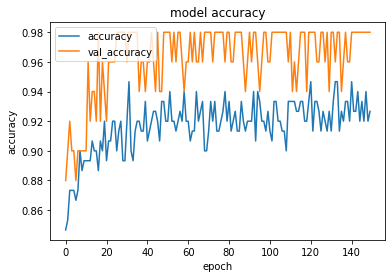

In [12]:
# строим график точности
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

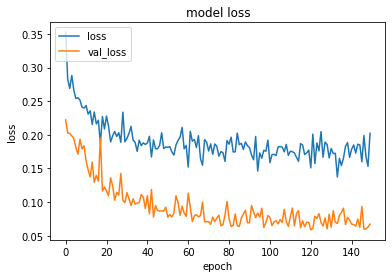

In [13]:
# строим график потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

Проверим модель на тестовой выборке

In [14]:
score=model.evaluate(x_test,y_test)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

200/200 [==============================] - 0s 126us/step

Test score: 0.3576906284689903
Test accuracy: 0.925000011920929


## Байесовский наивный классификтор

In [15]:
NB = GaussianNB()  
NB.fit(x_train, y_train)   
BNB=BernoulliNB()
BNB.fit(x_train, y_train)

C:\Users\Dmitry\Anaconda3\envs\neuro1\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Dmitry\Anaconda3\envs\neuro1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [16]:
y_predict_nb = NB.predict(x_test)  
y2_predict_bnb=BNB.predict(x_test)
print("Accuracy Normal NB: {:.2f}".format(NB.score(x_test, y_test)))
print("Accuracy Bernulli NB: {:.2f}".format(BNB.score(x_test, y_test)))

Accuracy Normal NB: 0.83
Accuracy Bernulli NB: 0.83


## Линейный дискриминантный анализ

In [17]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(x_train, y_train)

C:\Users\Dmitry\Anaconda3\envs\neuro1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [18]:
score_lda = LDA.score(x_test, y_test)
print("Linear Discriminant Analysis: ", score_lda)

Linear Discriminant Analysis:  0.855


## Квадратичный дискриминантный анализ

In [19]:
QDA = QuadraticDiscriminantAnalysis()
QDA.fit(x_train, y_train)

C:\Users\Dmitry\Anaconda3\envs\neuro1\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [20]:
score_qda = QDA.score(x_test, y_test) 
print("Quadratic Discriminant Analysis", score_qda)

Quadratic Discriminant Analysis 0.855


In [44]:
print('Neuro test accuracy:', score[1])
print("Accuracy Normal Naive Bayes: {:.2f}".format(NB.score(x_test, y_test)))
print("Accuracy Bernulli Naive Bayes: {:.2f}".format(BNB.score(x_test, y_test)))
print("Linear Discriminant Analysis: ", score_lda)
print("Quadratic Discriminant Analysis", score_qda)

Neuro test accuracy: 0.925000011920929
Accuracy Normal Naive Bayes: 0.83
Accuracy Bernulli Naive Bayes: 0.83
Linear Discriminant Analysis:  0.855
Quadratic Discriminant Analysis 0.855
